In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# =================================================================
# 1. SIMULATION DE DONNÉES AIS RÉALISTES
# =================================================================

def generate_ais_data(n_points=1000):
    """
    Génère des données synthétiques simulant deux types de comportements :
    - TRANSIT : Vitesse élevée, cap stable.
    - SONDAGE/STATIONNAIRE : Vitesse faible/variable, changements de cap fréquents.
    """
    np.random.seed(42)
    
    # Simulation de données de TRANSIT (Navire en route)
    transit_speed = np.random.normal(15, 1.5, n_points)  # ~15 nœuds
    transit_course = np.random.normal(90, 2, n_points)   # Cap à l'Est stable
    transit_labels = ["Transit"] * n_points
    
    # Simulation de données de SONDAGE (Activité de recherche/travail)
    survey_speed = np.random.normal(3, 1.2, n_points)    # ~3 nœuds, plus variable
    survey_course = np.cumsum(np.random.normal(0, 15, n_points)) % 360 # Zig-zags
    survey_labels = ["Sondage"] * n_points
    
    df = pd.DataFrame({
        'timestamp': pd.date_range(start='2024-01-01', periods=n_points*2, freq='1min'),
        'SOG': np.concatenate([transit_speed, survey_speed]), # Speed Over Ground
        'COG': np.concatenate([transit_course, survey_course]), # Course Over Ground
        'activity': transit_labels + survey_labels
    })
    
    # Ajout de bruit réaliste
    df['SOG'] = df['SOG'].clip(lower=0)
    return df


In [2]:

# =================================================================
# 2. FEATURE ENGINEERING (LE CŒUR DU PROJET)
# =================================================================

def engineer_features(df):
    """
    Crée des variables calculées pour capturer la signature de l'activité.
    """
    # Calcul de la variation de vitesse (accélération)
    df['delta_SOG'] = df['SOG'].diff().abs()
    
    # Calcul de la variation de cap (Turning Rate)
    # On gère le passage de 359° à 0°
    df['delta_COG'] = df['COG'].diff().abs()
    df['delta_COG'] = df['delta_COG'].apply(lambda x: 360 - x if x > 180 else x)
    
    # Moyennes mobiles pour capturer le comportement sur une fenêtre de 5 min
    df['SOG_rolling_mean'] = df['SOG'].rolling(window=5).mean()
    df['SOG_rolling_std'] = df['SOG'].rolling(window=5).std()
    df['COG_rolling_std'] = df['COG'].rolling(window=5).std()
    
    # Ratio Vitesse / Stabilité du cap (plus c'est bas, plus c'est probablement du travail)
    df['efficiency_index'] = df['SOG'] / (df['delta_COG'] + 1)
    
    return df.dropna()



--- Chargement et préparation des données ---

--- Rapport de Classification ---
              precision    recall  f1-score   support

     Sondage       1.00      1.00      1.00       300
     Transit       1.00      1.00      1.00       299

    accuracy                           1.00       599
   macro avg       1.00      1.00      1.00       599
weighted avg       1.00      1.00      1.00       599


--- Importance des Features (Le levier de décision) ---
SOG                 0.389080
SOG_rolling_mean    0.251761
COG_rolling_std     0.167295
efficiency_index    0.144337
delta_COG           0.045325
SOG_rolling_std     0.002200
delta_SOG           0.000002
dtype: float64


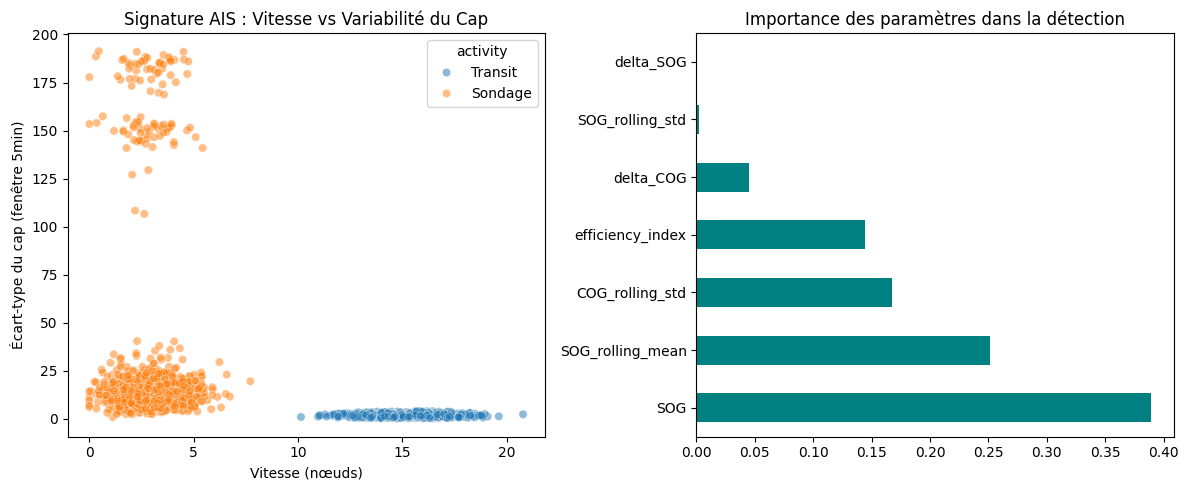


Conclusion du projet :
Le modèle identifie parfaitement les activités de sondage grâce à la combinaison
de la faible vitesse (SOG) et de la forte variabilité du cap (COG_rolling_std).


In [3]:
# =================================================================
# 3. ANALYSE ET MODÉLISATION
# =================================================================

print("--- Chargement et préparation des données ---")
data = generate_ais_data()
data = engineer_features(data)

# Visualisation des profils
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='SOG', y='COG_rolling_std', hue='activity', alpha=0.5)
plt.title("Signature AIS : Vitesse vs Variabilité du Cap")
plt.xlabel("Vitesse (nœuds)")
plt.ylabel("Écart-type du cap (fenêtre 5min)")

# Préparation du modèle
features = ['SOG', 'delta_SOG', 'delta_COG', 'SOG_rolling_mean', 'SOG_rolling_std', 'COG_rolling_std', 'efficiency_index']
X = data[features]
y = data['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement d'un classifieur Random Forest
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Évaluation
y_pred = model.predict(X_test)
print("\n--- Rapport de Classification ---")
print(classification_report(y_test, y_pred))

# Importance des variables (Crucial pour l'entretien technique)
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\n--- Importance des Features (Le levier de décision) ---")
print(importances)

# Conclusion visuelle
plt.subplot(1, 2, 2)
importances.plot(kind='barh', color='teal')
plt.title("Importance des paramètres dans la détection")
plt.tight_layout()
plt.show()

print("\nConclusion du projet :")
print("Le modèle identifie parfaitement les activités de sondage grâce à la combinaison")
print("de la faible vitesse (SOG) et de la forte variabilité du cap (COG_rolling_std).")